# Box Office Movie Franchise Predictor - Modeling

## Introduction

The original goal of the project is to predict box office returns of a movie sequel given data of its original or its precursor.

**NOTE**: Sequels that made over 1,000% its original are removed 

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
from pprint import pprint

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.linear_model import ElasticNet,BayesianRidge,HuberRegressor
from sklearn.linear_model import ARDRegression,SGDRegressor
from sklearn.model_selection import KFold,train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR

import lightgbm as lgbm
import xgboost as xgb

from sklearn.metrics import mean_squared_error,make_scorer,r2_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

%config InlineBackend.figure_format='retina'

## Constants

In [2]:
pct_cut_off = 500

test_size = 0.20

seed = 1234

## Load Data File(s)

In [3]:
data_path = './data/'

file_all = 'movies_with_sequels_final_cleaned.csv'
file_org = 'movies_with_originals_only_final_cleaned.csv'
file_seq = 'movies_with_sequels_only_final_cleaned.csv'

df_all = pd.read_csv(data_path + file_all)
df_org = pd.read_csv(data_path + file_org)
df_seq = pd.read_csv(data_path + file_seq)

In [4]:
df_all['Release Date'] = pd.to_datetime(df_all['Release Date'])
df_org['Release Date'] = pd.to_datetime(df_org['Release Date'])
df_seq['Release Date'] = pd.to_datetime(df_seq['Release Date'])

In [5]:
# Get 
def diff_rel_dates(data_org,data_seq,delta_type):
    
    delta_time = (data_seq['Release Date'] - data_org['Release Date'])/np.timedelta64(1, delta_type)
    
    neg_delta = delta_time[delta_time < 0]
    
    if neg_delta is not None:
        print('No negative difference')
    else:
        print('There are negative time(s) between sequel and original. Please check!')

    return delta_time

In [6]:
# Set years as the difference between sequel and original
diff_type = 'Y'

diff_time = diff_rel_dates(df_org,df_seq,diff_type)

No negative difference


In [7]:
df_org.head()

,Title,url,IMDB Score,Metacritic,Runtime (mins),Budget,Opening Weekend,Gross USA,Gross World,Release Date,Rating,Genres,Country
0,Spider-Man (2002),http://www.imdb.com/title/tt0145487/,7.3,73.0,121,139000000.0,114844116.0,407022860.0,8.250250e+08,2002-05-03,PG-13,Action Adventure Sci-Fi,USA
1,The Matrix (1999),http://www.imdb.com/title/tt0133093/,8.7,73.0,136,63000000.0,27788331.0,171479930.0,4.653438e+08,1999-03-31,R,Action Sci-Fi,USA
2,The Lord of the Rings: The Fellowship of the R...,http://www.imdb.com/title/tt0120737/,8.8,92.0,178,93000000.0,47211490.0,315544750.0,8.878328e+08,2001-12-19,PG-13,Action Adventure Drama,New Zealand
3,The Lord of the Rings: The Return of the King ...,http://www.imdb.com/title/tt0167260/,8.9,94.0,201,94000000.0,72629713.0,377845905.0,1.142219e+09,2003-12-17,PG-13,Adventure Drama Fantasy,New Zealand
4,The Hobbit: The Desolation of Smaug (2013),http://www.imdb.com/title/tt1170358/,7.8,66.0,161,225000000.0,73645197.0,258366855.0,9.583669e+08,2013-12-13,PG-13,Adventure Fantasy,New Zealand


In [8]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            539 non-null    object        
 1   url              539 non-null    object        
 2   IMDB Score       539 non-null    float64       
 3   Metacritic       505 non-null    float64       
 4   Runtime (mins)   539 non-null    int64         
 5   Budget           539 non-null    float64       
 6   Opening Weekend  475 non-null    float64       
 7   Gross USA        508 non-null    float64       
 8   Gross World      539 non-null    float64       
 9   Release Date     539 non-null    datetime64[ns]
 10  Rating           539 non-null    object        
 11  Genres           539 non-null    object        
 12  Country          539 non-null    object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(5)
memory usage: 54.9+ KB


## Feature Engineering

### Select Target

The target variable is the box office return of its sequel or subsequent film

In [9]:
# Attach the target variable (Gross Returns from the Suquel) to df_org dataframe and rescale
df_org['target'] = np.log(df_seq['Gross World'])


### Removing Outliers

Based on the EDA portion of this study, I noticed that Gross Sequel vs. Gross Original contained several outliers. They were notably:

1. The Boondock Saints 1 & 2 (> 30k% difference)
2. Dominion || The Last Exorcism
3. Night of the Living Dead || Dawn of the Dead
4. Enthiran || 2.0
5. Mesrine 1 and 2
6. Skyline 1 and 2

and many others. The systematic way to remove outliers is to consider a percentage bandwidth. If movie sequels severely outperformed or underperformed compared to its original say for example above or below 1,000% then we will remove this movies. The user has control of the bandwidth. Note, the narrower the bandwidth the more observations you remove and thus you end-up with less data to train and test.

In [10]:
def remove_outliers(data_org,data_seq,pct_cut_off):

    df_temp = data_org[['Title']]
    df_temp['Gross Original'] = data_org['Gross World']
    df_temp['Gross Sequel'] = df_seq['Gross World']

    # Calculate percentage differces
    df_temp['MinGross_SeqOrg'] =  df_temp[['Gross Original', 'Gross Sequel']].min(axis=1)
    df_temp['GrossPercentDiff'] = round((df_temp['Gross Sequel'] - df_temp['Gross Original'])/df_temp['MinGross_SeqOrg']*100,2)
    df_temp['AbsGrossPercentDiff'] = round(np.abs(df_temp['Gross Sequel'] - df_temp['Gross Original'])/df_temp['MinGross_SeqOrg']*100,2)

    df_mov_pct_cut = df_temp[(df_temp['AbsGrossPercentDiff'] > pct_cut_off) | (df_temp['AbsGrossPercentDiff'] < -1*pct_cut_off)]

    # Remove suggested outliers that lay outside of the bandwidth
    data_org = data_org.drop(df_mov_pct_cut.index)
    data_org = data_org.reset_index(drop=True)
    
    
    print('\nRemoved: ',len(df_mov_pct_cut),'observations with, {}%, cut-off'.format(pct_cut_off))
        
    print()
    print()
    
    return data_org

In [11]:
df_org = remove_outliers(df_org,df_seq,pct_cut_off)

# Assign the target variable
y = df_org['target']

df_org.info()


Removed:  51 observations with, 500%, cut-off


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            488 non-null    object        
 1   url              488 non-null    object        
 2   IMDB Score       488 non-null    float64       
 3   Metacritic       458 non-null    float64       
 4   Runtime (mins)   488 non-null    int64         
 5   Budget           488 non-null    float64       
 6   Opening Weekend  431 non-null    float64       
 7   Gross USA        461 non-null    float64       
 8   Gross World      488 non-null    float64       
 9   Release Date     488 non-null    datetime64[ns]
 10  Rating           488 non-null    object        
 11  Genres           488 non-null    object        
 12  Country          488 non-null    object        
 13  target           488 non-null    float64      

### Drop Features

We will drop a number of features here:

1. Title and url

2. Metacritic Score. Too many missing values here and imputing these is perhaps not a good idea as it could skew the results as the dataset is not large enough. This will be removed for now. We could test imputation later.

3. Gross USA and Opening Weekend numbers. Again, a lot missing here and imputing can be dangerous.

In [12]:
cols_to_drop = ['Title','url','Metacritic','Opening Weekend', 'Gross USA','Country','target']

df_org.drop(cols_to_drop,axis=1,inplace=True)

In [13]:
df_org.head()

,IMDB Score,Runtime (mins),Budget,Gross World,Release Date,Rating,Genres
0,7.3,121,139000000.0,8.250250e+08,2002-05-03,PG-13,Action Adventure Sci-Fi
1,8.7,136,63000000.0,4.653438e+08,1999-03-31,R,Action Sci-Fi
2,8.8,178,93000000.0,8.878328e+08,2001-12-19,PG-13,Action Adventure Drama
3,8.9,201,94000000.0,1.142219e+09,2003-12-17,PG-13,Adventure Drama Fantasy
4,7.8,161,225000000.0,9.583669e+08,2013-12-13,PG-13,Adventure Fantasy


In [14]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   IMDB Score      488 non-null    float64       
 1   Runtime (mins)  488 non-null    int64         
 2   Budget          488 non-null    float64       
 3   Gross World     488 non-null    float64       
 4   Release Date    488 non-null    datetime64[ns]
 5   Rating          488 non-null    object        
 6   Genres          488 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 26.8+ KB


### One-Hot-Encoding

#### Rating

In [15]:
df_rating = pd.get_dummies(df_org['Rating'],prefix = 'r', drop_first=False)

df_rating.head()

,r_G,r_PG,r_PG-13,r_R
0,0,0,1,0
1,0,0,0,1
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


#### Genres

In [16]:
# Nice tip from Jeremy Cunningham
df_genres_temp = df_org.Genres.str.split(' ', expand=True).stack()

df_genres = pd.get_dummies(df_genres_temp, prefix='g').groupby(level=0).max()

df_genres = df_genres.reset_index()

df_genres.drop(['index'],axis=1,inplace=True)

df_genres.head()

,g_Action,g_Adventure,g_Animation,g_Biography,g_Comedy,g_Crime,g_Documentary,g_Drama,g_Family,g_Fantasy,...,g_Horror,g_Music,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Sport,g_Thriller,g_War,g_Western
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   g_Action       488 non-null    uint8
 1   g_Adventure    488 non-null    uint8
 2   g_Animation    488 non-null    uint8
 3   g_Biography    488 non-null    uint8
 4   g_Comedy       488 non-null    uint8
 5   g_Crime        488 non-null    uint8
 6   g_Documentary  488 non-null    uint8
 7   g_Drama        488 non-null    uint8
 8   g_Family       488 non-null    uint8
 9   g_Fantasy      488 non-null    uint8
 10  g_History      488 non-null    uint8
 11  g_Horror       488 non-null    uint8
 12  g_Music        488 non-null    uint8
 13  g_Musical      488 non-null    uint8
 14  g_Mystery      488 non-null    uint8
 15  g_Romance      488 non-null    uint8
 16  g_Sci-Fi       488 non-null    uint8
 17  g_Sport        488 non-null    uint8
 18  g_Thriller     488 non-null    uint8
 19  g_War   

In [18]:
# Combine the two
df_ratings_genres = pd.concat([df_rating, df_genres], axis=1)

df_ratings_genres.head()

,r_G,r_PG,r_PG-13,r_R,g_Action,g_Adventure,g_Animation,g_Biography,g_Comedy,g_Crime,...,g_Horror,g_Music,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Sport,g_Thriller,g_War,g_Western
0,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Dates

In [19]:
df_org['deltaYears'] = diff_time

#df_org['rel_YearOrg']  = df_org['Release Date'].dt.year
df_org['MonthOrg'] = df_org['Release Date'].dt.month
df_org['DOWOrg']   = df_org['Release Date'].dt.dayofweek
df_org['DayOrg']   = df_org['Release Date'].dt.day

In [20]:
df_org.head()

,IMDB Score,Runtime (mins),Budget,Gross World,Release Date,Rating,Genres,deltaYears,MonthOrg,DOWOrg,DayOrg
0,7.3,121,139000000.0,8.250250e+08,2002-05-03,PG-13,Action Adventure Sci-Fi,2.160209,5,4,3
1,8.7,136,63000000.0,4.653438e+08,1999-03-31,R,Action Sci-Fi,4.123288,3,2,31
2,8.8,178,93000000.0,8.878328e+08,2001-12-19,PG-13,Action Adventure Drama,0.996598,12,2,19
3,8.9,201,94000000.0,1.142219e+09,2003-12-17,PG-13,Adventure Drama Fantasy,8.994025,12,2,17
4,7.8,161,225000000.0,9.583669e+08,2013-12-13,PG-13,Adventure Fantasy,1.010288,12,4,13


In [21]:
#df_org = pd.concat([df_org,df_ratings_genres], axis=1)

df_rel_time = df_org[['MonthOrg','DOWOrg','DayOrg']]

df_org.drop(['Rating','Genres', 'Release Date'], axis=1, inplace=True)

df_org.head()

,IMDB Score,Runtime (mins),Budget,Gross World,deltaYears,MonthOrg,DOWOrg,DayOrg
0,7.3,121,139000000.0,8.250250e+08,2.160209,5,4,3
1,8.7,136,63000000.0,4.653438e+08,4.123288,3,2,31
2,8.8,178,93000000.0,8.878328e+08,0.996598,12,2,19
3,8.9,201,94000000.0,1.142219e+09,8.994025,12,2,17
4,7.8,161,225000000.0,9.583669e+08,1.010288,12,4,13


In [22]:
df_rel_time = df_rel_time.reset_index(drop=True)
df_rel_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   MonthOrg  488 non-null    int64
 1   DOWOrg    488 non-null    int64
 2   DayOrg    488 non-null    int64
dtypes: int64(3)
memory usage: 11.6 KB


### Numeric Columns

In [23]:
# Transform Budget and Gross into Log numbers
df_org['LogBudget'] = np.log(df_org['Budget'])
df_org['LogGross']  = np.log(df_org['Gross World'])

df_org.drop(['Budget','Gross World'], axis=1, inplace=True)

df_org.rename(columns = {'Runtime (mins)':'Runtime'}, inplace = True)

In [24]:
df_org.head()

,IMDB Score,Runtime,deltaYears,MonthOrg,DOWOrg,DayOrg,LogBudget,LogGross
0,7.3,121,2.160209,5,4,3,18.749984,20.530924
1,8.7,136,4.123288,3,2,31,17.958645,19.958287
2,8.8,178,0.996598,12,2,19,18.348110,20.604294
3,8.9,201,8.994025,12,2,17,18.358805,20.856239
4,7.8,161,1.010288,12,4,13,19.231611,20.680741


In [25]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IMDB Score  488 non-null    float64
 1   Runtime     488 non-null    int64  
 2   deltaYears  488 non-null    float64
 3   MonthOrg    488 non-null    int64  
 4   DOWOrg      488 non-null    int64  
 5   DayOrg      488 non-null    int64  
 6   LogBudget   488 non-null    float64
 7   LogGross    488 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 30.6 KB


## Design Matrix & Modeling

I will test several options here to see which generates the best R^2 Score

1. IMDB Score, Runtime, deltaYears, LogBudget and LogGross

2. Number 1 with rel_YearOrg, rel_MonthOrg,...

3. Number 2 with Ratings

4. Number 3 with Genres

### Helper Functions

In [26]:
def model_training(train,target,option):
    
    results = {}
    
    def test_model(clf):
        
        cv = KFold(n_splits=5,shuffle=True,random_state=2021)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, target, cv=cv,scoring=r2)
        scores = [r2_val_score.mean()]
        
        return scores
    
    # Alpha parameter for Ridge, Lasso and ElasticNet
    alpha = 0.001

    model = LinearRegression()
    results["Linear"] = test_model(model)

    model = Ridge(alpha=alpha)
    results["Ridge"]=test_model(model)

    model = BayesianRidge()
    results["Bayesian Ridge"]=test_model(model)
    
    model = ARDRegression()
    results["ARD Regressor"]=test_model(model)
    
    model = SGDRegressor()
    results["SGD Regressor"]=test_model(model)   

    model = HuberRegressor()
    results["Hubber"]=test_model(model)

    model = Lasso(alpha=alpha)
    results["Lasso"]=test_model(model)
    
    model = ElasticNet(alpha=alpha)
    results["ElasticNet"]=test_model(model)
    
    model = SVR(kernel='linear')
    results["SVR-Linear"]=test_model(model)
    
    model = SVR(kernel='poly')
    results["SVR-poly"]=test_model(model)
    
    model = SVR(kernel='rbf')
    results["SVR-RBF"]=test_model(model)
    
    #model = SVR(kernel='precomputed')
    #results["SVR-precomputed"]=test_model(model)
    
    model = RandomForestRegressor(n_estimators=500, n_jobs=4, max_depth=5)
    results["RandomForest"] = test_model(model)

    model = AdaBoostRegressor(n_estimators=500,learning_rate=0.001)
    results["AdaBoost"] = test_model(model)
    
    model = lgbm.LGBMRegressor(n_estimators=500,n_jobs=4, max_depth=5, num_leaves=30)
    results["LightGBM"] = test_model(model)
    
    model = xgb.XGBRegressor(n_estimators=500,n_jobs=4, max_depth=5)
    results["XGBoost"] = test_model(model)
    
    df_results = pd.DataFrame.from_dict(results,orient='index')
    df_results.columns = ["R-Squared Score"] 
    df_results = df_results.sort_values(by='R-Squared Score',ascending=False)
    
    ax = df_results.plot(kind="bar",title="Model Scores, Option {}".format(option),figsize=(12,5))
    ax.set_ylabel('R-Squared Values')
    #ax.xticks(rotation=45)
    
    plt.gca()
    plt.ylim(0.5, 0.9)
    plt.xticks(rotation=40)
    plt.savefig('./images/model_r2_scores_option'+ str(option) +'.svg')
    plt.savefig('./images/model_r2_scores_option'+ str(option) +'.png')
    
    return df_results

In [27]:
def opt_best_model(model_select,params,X_train,y_train):

    model = RandomizedSearchCV(estimator = model_select, 
                               param_distributions = params, 
                               cv = 5, scoring = 'r2')

    model_best = model.fit(X_train, y_train)

    pprint(model_best.best_estimator_.get_params())

    pprint(model_best.best_estimator_)
    
    return model_best

In [28]:
def model_best_predict(opt_model,X_train,X_test,y_train,y_test):
    
    # Make an estimation based on the best model
    opt_model.best_estimator_.fit(X_train,y_train)

    r2_score = model_best.best_estimator_.score(X_train,y_train)

    print('R2-Score   : {:.6f}'.format(r2_score))

    y_pred_train = np.exp(opt_model.best_estimator_.predict(X_train))
    y_pred_test  = np.exp(opt_model.best_estimator_.predict(X_test))

    rmse_train = np.sqrt(mean_squared_error(np.exp(y_train),y_pred_train))
    rmse_test  = np.sqrt(mean_squared_error(np.exp(y_test),y_pred_test))

    print('RMSE-Train : ${:,.2f}'.format(rmse_train))
    print('RMSE-Test  : ${:,.2f}'.format(rmse_test))

    coeffs = opt_model.best_estimator_.coef_.ravel()
    
    return coeffs

In [29]:
def plot_coefficients(X,coeffs,option,bartype='v'):

    variables = list(X.columns)

    # Name change...I know this can be improved
    for i in range(len(variables)):
        if variables[i] == 'LogGross':
            variables[i] = 'Gross'
    
        if variables[i] == 'LogBudget':
            variables[i] = 'Budget'

    # Get sorted index but in reverse
    ind = list(np.argsort(coeffs))[::-1]
    coeff = list(np.sort(coeffs))[::-1]

    # Reorder variables
    variables = [variables[i] for i in ind]
    
    if bartype == 'v':
        plt.figure(figsize=(16,6))
        plt.bar(variables, coeff,color=['r','g','b','k','c','pink','orange'])
    else:
        plt.figure(figsize=(8,16))
        plt.barh(variables, coeff,color=['r','g','b','k','c','pink','orange'])
        
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=12)
    plt.ylabel('Regression Coefficients for Option '+ str(option),fontsize=14)
    plt.title('Regression Coefficients Option '+ str(option),fontsize=16)
    
    plt.savefig('./images/coefficients_option' + str(option) +'.svg')
    plt.savefig('./images/coefficients_option' + str(option) +'.png')

In [30]:
# Get a picture of the skedasticity

def plot_residuals(model,X_test,y_test,zoom,option):
    
    y_pred_test = np.exp(model_best.predict(X_test))

    pct_residuals = (y_pred_test - np.exp(y_test))/np.exp(y_test)*100

    plt.figure(figsize=(14,6))
    plt.scatter(y_pred_test/1e6,pct_residuals,color='red');
    
    plt.xlabel('Predicted Box Office Sequel (USD), Millions',fontsize=14);
    plt.ylabel('Percent Residual (%)',fontsize=14);
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.xticks(np.arange(0, 2000+1, 100))
    
    if zoom == 'Y':
        plt.axis([-10, 2000, -250, 1000])
    
    plt.axhline(y = 0, color='black');
    
    plt.grid()
    
    if zoom == 'Y':
        plt.savefig('./images/residuals_option_{}_zoom.svg'.format(option))
        plt.savefig('./images/residuals_option_{}_zoom.png'.format(option))
        plt.title('Residual vs Predicted Box Office Returns, Option {}, Zoom'.format(option),fontsize=16);
    else:
        plt.savefig('./images/residuals_option_{}.svg'.format(option))
        plt.savefig('./images/residuals_option_{}.png'.format(option))
        plt.title('Residual vs Predicted Box Office Returns, Option {}'.format(option),fontsize=16);

#pct_residuals

### Modeling - Option 1

In [31]:
X1 = df_org.drop(['MonthOrg','DOWOrg','DayOrg'], axis=1)

X1.head()

,IMDB Score,Runtime,deltaYears,LogBudget,LogGross
0,7.3,121,2.160209,18.749984,20.530924
1,8.7,136,4.123288,17.958645,19.958287
2,8.8,178,0.996598,18.348110,20.604294
3,8.9,201,8.994025,18.358805,20.856239
4,7.8,161,1.010288,19.231611,20.680741


In [32]:
X1 = X1.reset_index(drop=True)

X1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IMDB Score  488 non-null    float64
 1   Runtime     488 non-null    int64  
 2   deltaYears  488 non-null    float64
 3   LogBudget   488 non-null    float64
 4   LogGross    488 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 19.2 KB


In [33]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=test_size, random_state=1234)

In [34]:
X1_train.shape

(390, 5)

In [35]:
X1_test.shape

(98, 5)

In [36]:
# Standardize training data
sc1 = StandardScaler()

X1_train_scaled = pd.DataFrame(sc1.fit_transform(X1_train), columns=X1_train.columns)
X1_test_scaled  = pd.DataFrame(sc1.transform(X1_test), columns=X1_test.columns)

,R-Squared Score
Ridge,0.827532
Linear,0.827532
ElasticNet,0.827531
Bayesian Ridge,0.827530
Lasso,0.827524
Hubber,0.827250
SGD Regressor,0.826765
ARD Regressor,0.826689
SVR-Linear,0.824761
RandomForest,0.798437


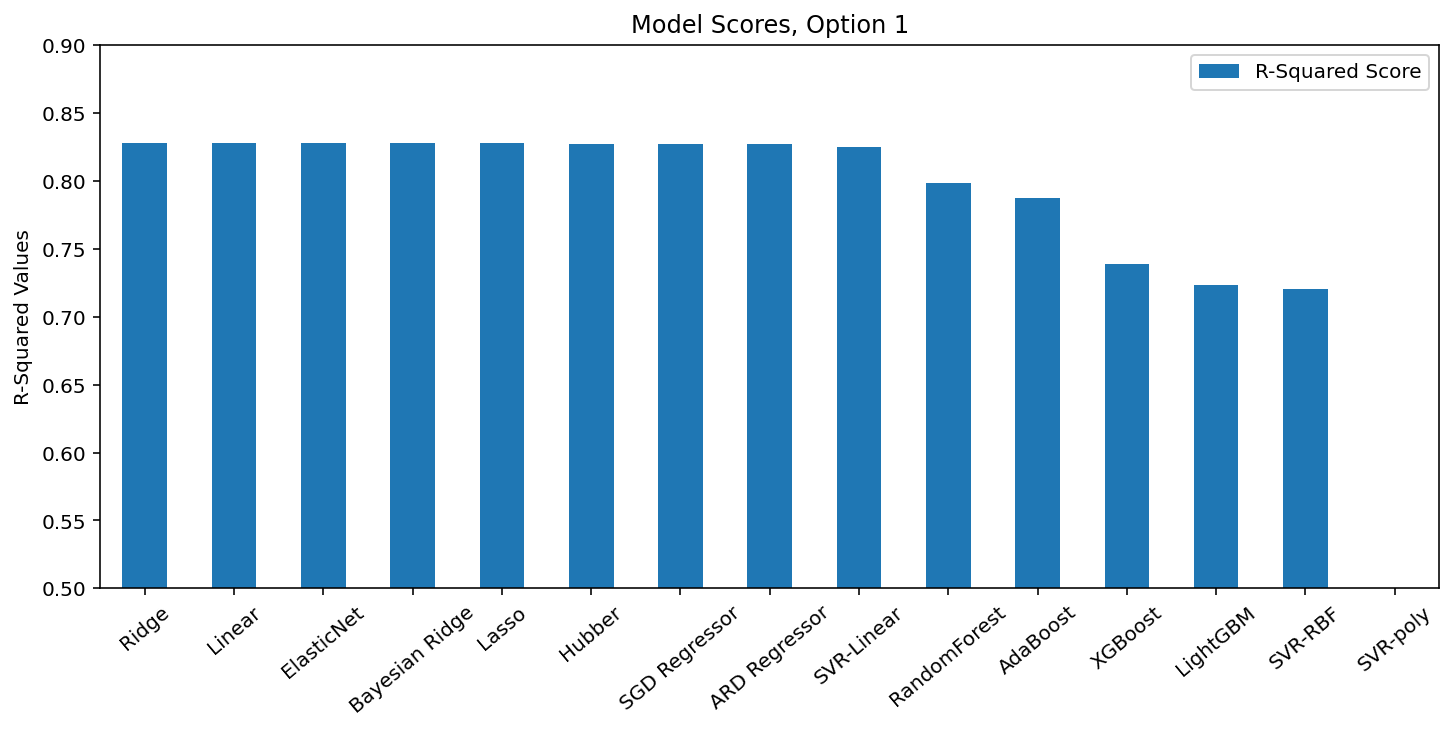

In [37]:
option = 1

df_results_option_1 = model_training(X1_train_scaled,y1_train,option)

df_results_option_1

In [38]:
# Pick a model and perform hyper-parameter tuning

model_select = BayesianRidge()

params = {'alpha_1' : [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'alpha_2' : [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'lambda_1': [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'lambda_2': [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'fit_intercept' : [False,True],
          'n_iter' : [100,200,300,400,500,600,700,800,900,1000]
         }

model_best = opt_best_model(model_select,params,X1_train_scaled,y1_train)

print()
print()

model_coeffs = model_best_predict(model_best,X1_train_scaled,X1_test_scaled,y1_train,y1_test)


{'alpha_1': 1e-07,
 'alpha_2': 0.2,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 0.2,
 'lambda_2': 1e-07,
 'n_iter': 300,
 'normalize': False,
 'tol': 0.001,
 'verbose': False}
BayesianRidge(alpha_1=1e-07, alpha_2=0.2, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=0.2, lambda_2=1e-07, n_iter=300,
              normalize=False, tol=0.001, verbose=False)


R2-Score   : 0.834375
RMSE-Train : $168,821,193.76
RMSE-Test  : $141,367,761.97


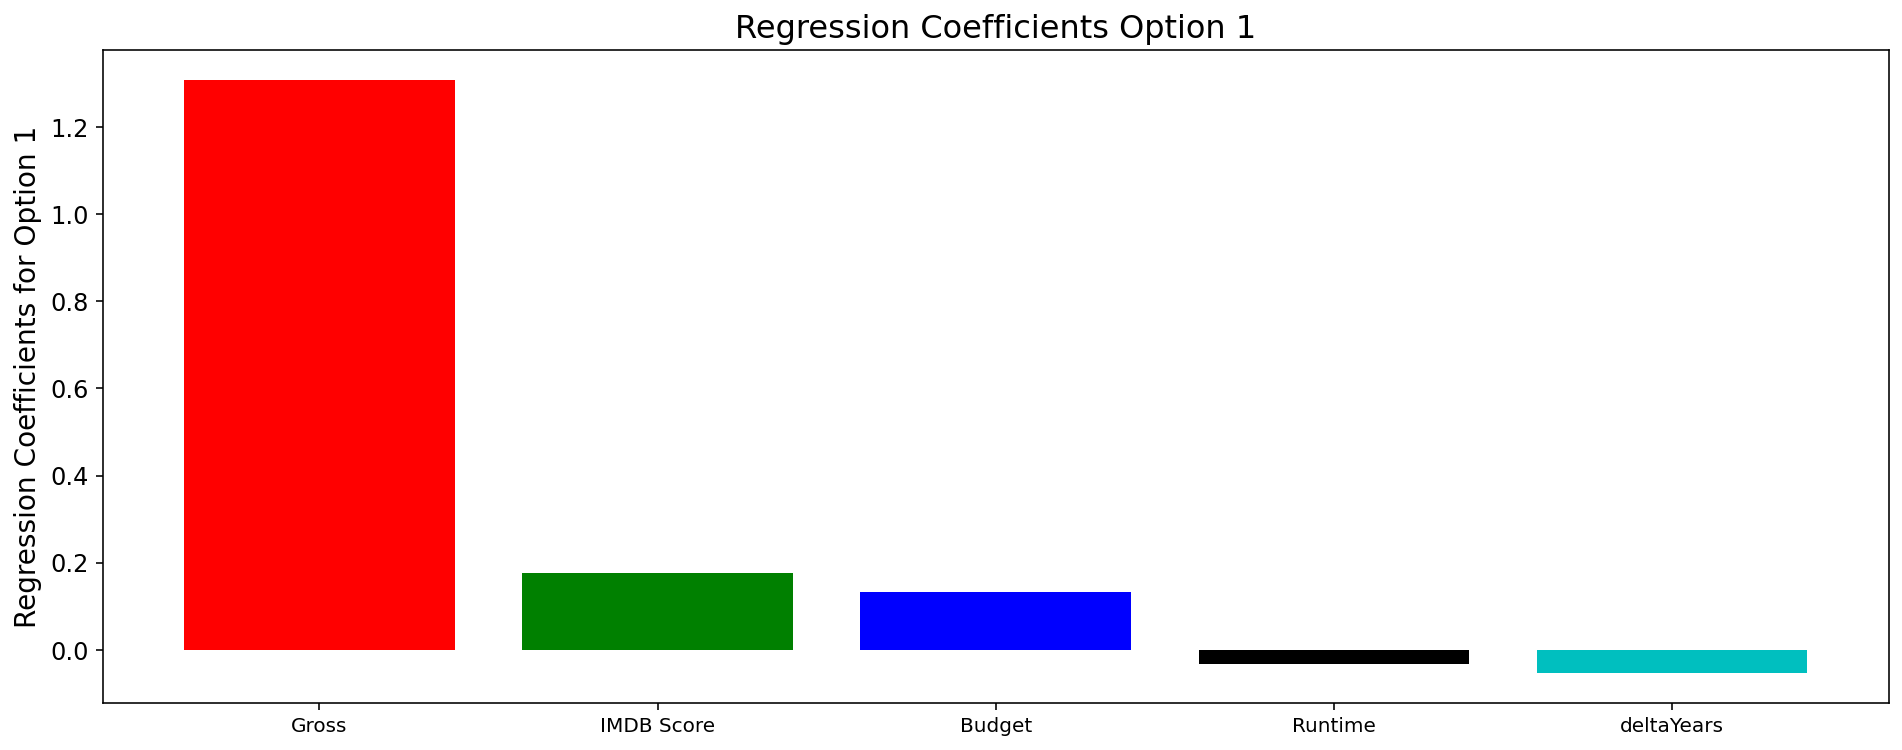

In [39]:
plot_coefficients(X1_train_scaled,model_coeffs,1)

#### Plot Residuals

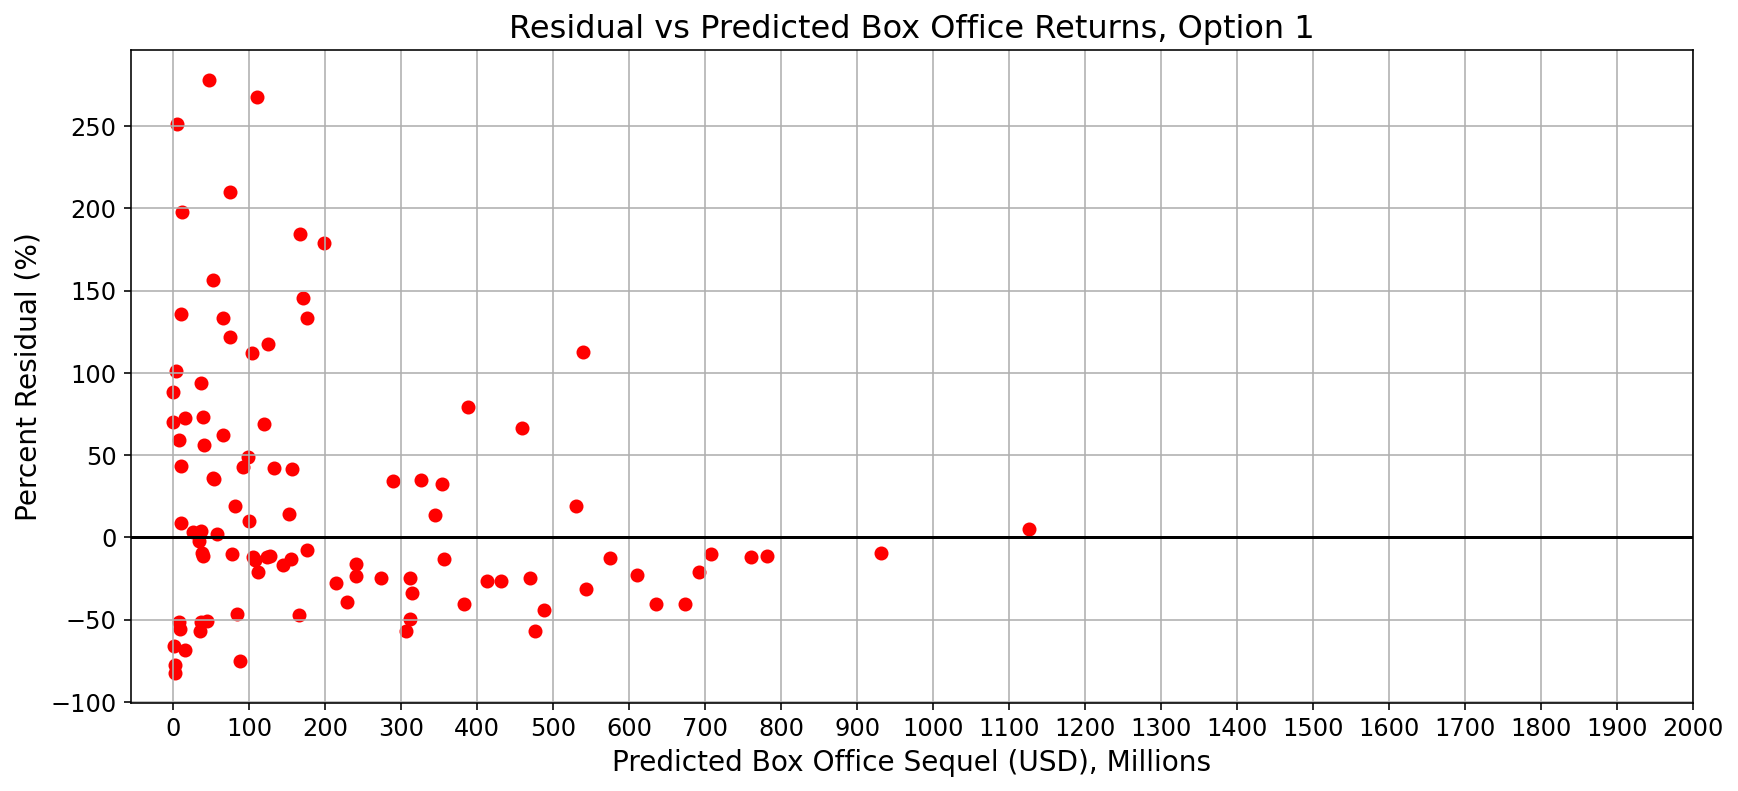

In [40]:
option = 1
zoom = 'N'

plot_residuals(model_best,X1_test_scaled,y1_test,zoom,1)

There are still a number of outliers here that the model cannot predict really well. Notice the discrepancy of over 1,000%. These could most likely be sequels that severely over-performed or under-performed compared to its original. Notice that the original movie perhaps did not make very much at the time and suddenly because of say it becoming a cult-classic, its sequel becomes extremely popular.

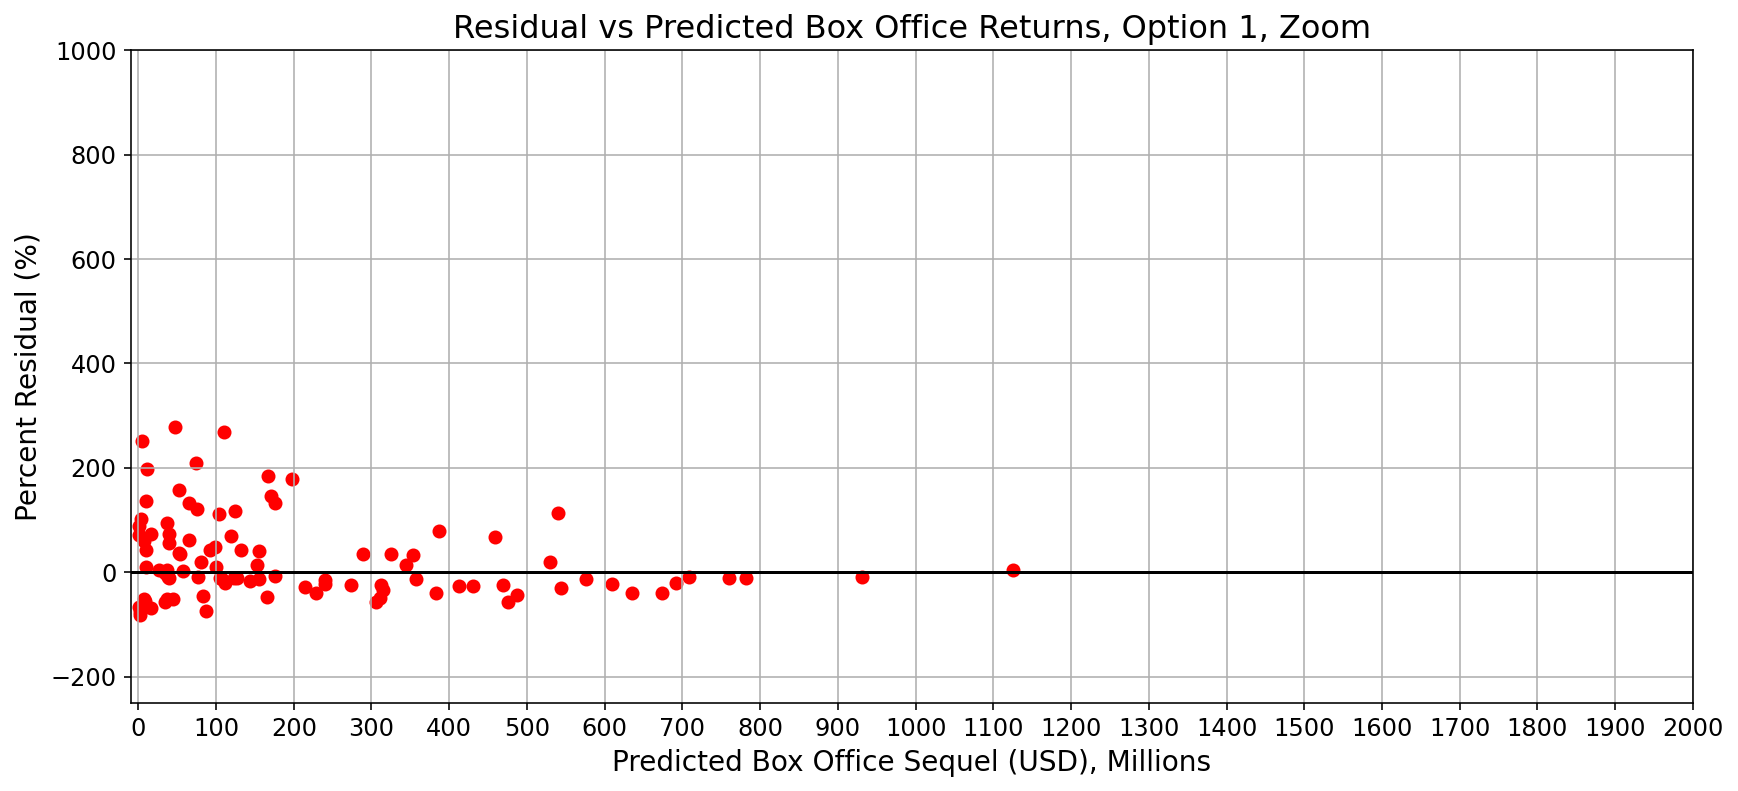

In [41]:
option = 1
zoom = 'Y'

plot_residuals(model_best,X1_test_scaled,y1_test,zoom,1)

Based on our EDA, it is no surprise that the returns of the original strongly dictates the direction of its sequel. It is then followed by its budget and IMDB score. The period between release has a slight effect. The runtime however, has a slight negative effect. In this case, perhaps do not have a too long of a movie.

To check this further, one has to find out which data points is causing the large percent residual error. Look at the one that is close to 1,000% error and check which movie it is. Those could potentially be outliers that is adversely affecting the model.

### Modeling - Option 2

2. Number 1 with rel_YearOrg, rel_MonthOrg,...

In [42]:
X2 = pd.concat([X1, df_rel_time], axis=1)

X2 = X2.reset_index(drop=True) 
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IMDB Score  488 non-null    float64
 1   Runtime     488 non-null    int64  
 2   deltaYears  488 non-null    float64
 3   LogBudget   488 non-null    float64
 4   LogGross    488 non-null    float64
 5   MonthOrg    488 non-null    int64  
 6   DOWOrg      488 non-null    int64  
 7   DayOrg      488 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 30.6 KB


In [43]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=test_size, random_state=1234)

# Standardize training data
sc2 = StandardScaler()

X2_train_scaled = pd.DataFrame(sc2.fit_transform(X2_train), columns=X2_train.columns)
X2_test_scaled  = pd.DataFrame(sc2.transform(X2_test), columns=X2_test.columns)

,R-Squared Score
Lasso,0.831461
ElasticNet,0.831436
Bayesian Ridge,0.831435
Ridge,0.831396
Linear,0.831396
Hubber,0.831230
ARD Regressor,0.830544
SVR-Linear,0.830296
SGD Regressor,0.829879
RandomForest,0.803415


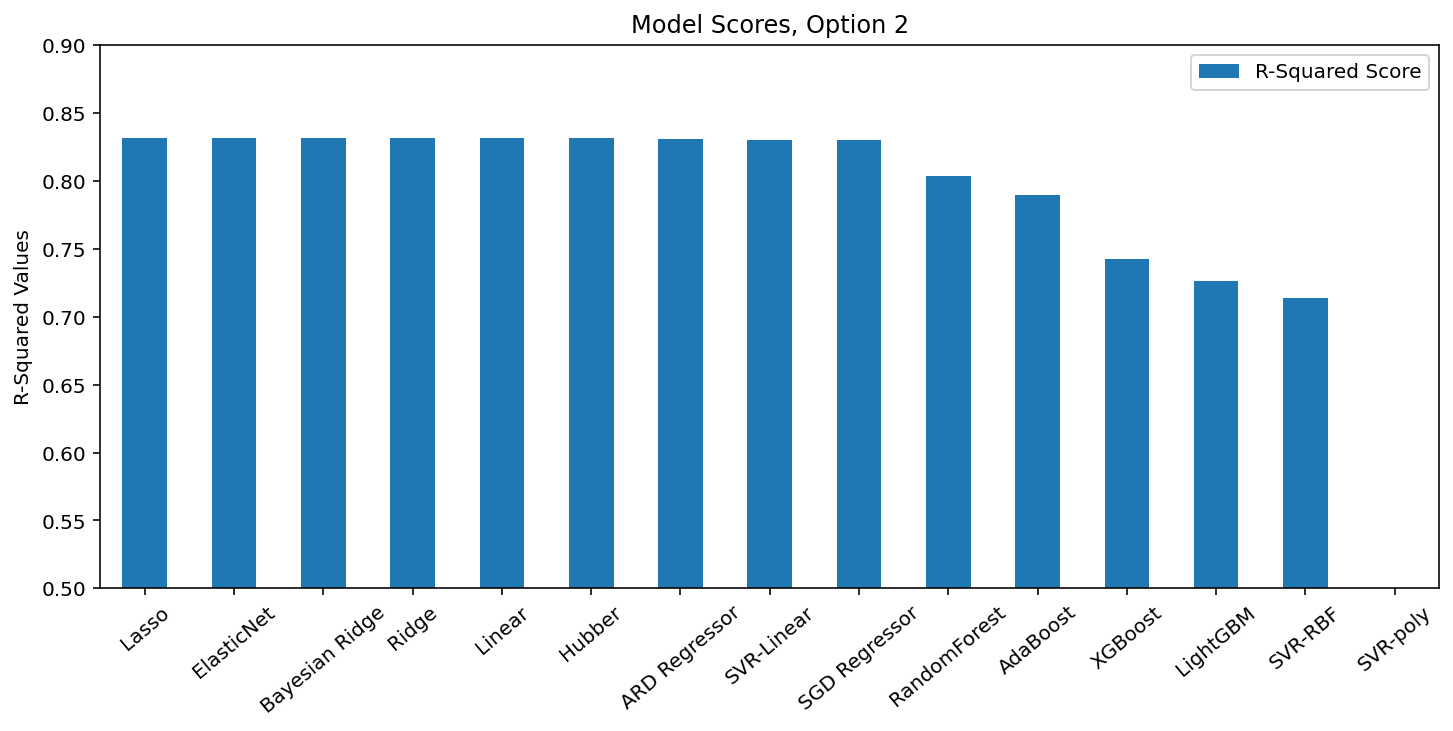

In [44]:
df_results_option_2 = model_training(X2_train_scaled,y2_train,2)

df_results_option_2

In [45]:
model_select = BayesianRidge()

params = {'alpha_1' : [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'alpha_2' : [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'lambda_1': [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'lambda_2': [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'fit_intercept' : [False,True],
          'n_iter' : [100,200,300,400,500,600,700,800,900,1000]
         }
    
model_best = opt_best_model(model_select,params,X2_train_scaled,y2_train)

print()
print()

model_coeffs = model_best_predict(model_best,X2_train_scaled,X2_test_scaled,y2_train,y2_test)
    

{'alpha_1': 0,
 'alpha_2': 1e-06,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 0.3,
 'lambda_2': 0.0001,
 'n_iter': 1000,
 'normalize': False,
 'tol': 0.001,
 'verbose': False}
BayesianRidge(alpha_1=0, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=0.3, lambda_2=0.0001, n_iter=1000,
              normalize=False, tol=0.001, verbose=False)


R2-Score   : 0.841058
RMSE-Train : $170,457,043.63
RMSE-Test  : $144,473,235.42


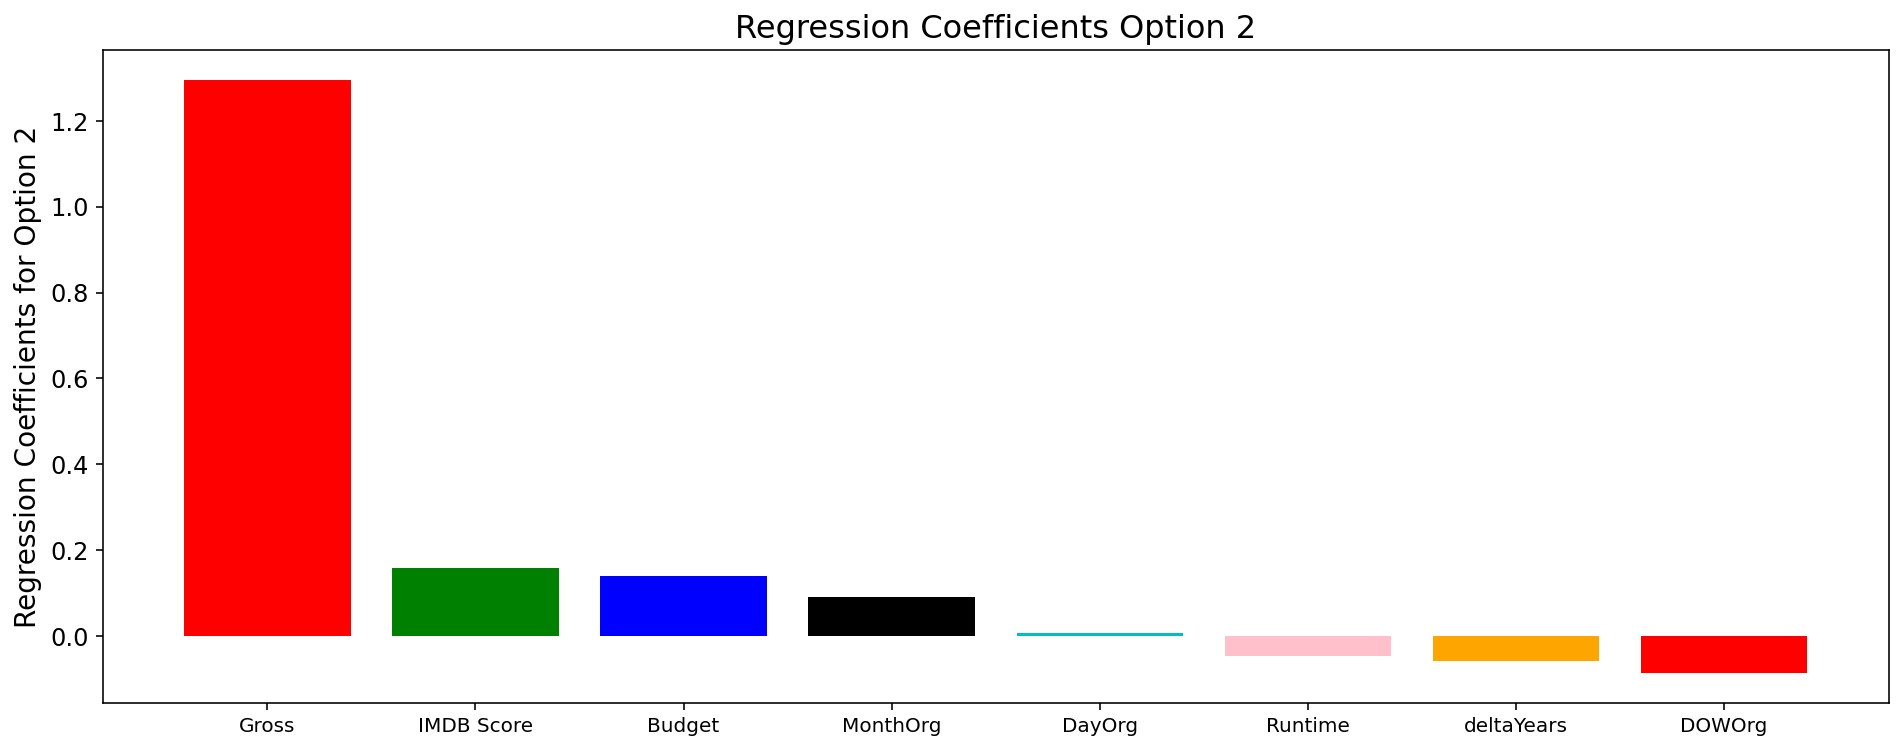

In [46]:
plot_coefficients(X2_train_scaled,model_coeffs,2)

### Modeling - Option 3

3. Number 2 with Ratings

In [47]:
X3 = pd.concat([X2, df_rating], axis=1)

X3.head()

,IMDB Score,Runtime,deltaYears,LogBudget,LogGross,MonthOrg,DOWOrg,DayOrg,r_G,r_PG,r_PG-13,r_R
0,7.3,121,2.160209,18.749984,20.530924,5,4,3,0,0,1,0
1,8.7,136,4.123288,17.958645,19.958287,3,2,31,0,0,0,1
2,8.8,178,0.996598,18.348110,20.604294,12,2,19,0,0,1,0
3,8.9,201,8.994025,18.358805,20.856239,12,2,17,0,0,1,0
4,7.8,161,1.010288,19.231611,20.680741,12,4,13,0,0,1,0


In [48]:
# Check indices again
X3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IMDB Score  488 non-null    float64
 1   Runtime     488 non-null    int64  
 2   deltaYears  488 non-null    float64
 3   LogBudget   488 non-null    float64
 4   LogGross    488 non-null    float64
 5   MonthOrg    488 non-null    int64  
 6   DOWOrg      488 non-null    int64  
 7   DayOrg      488 non-null    int64  
 8   r_G         488 non-null    uint8  
 9   r_PG        488 non-null    uint8  
 10  r_PG-13     488 non-null    uint8  
 11  r_R         488 non-null    uint8  
dtypes: float64(4), int64(4), uint8(4)
memory usage: 32.5 KB


In [49]:
# Do the usual train test split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=test_size, random_state=1234)

#X3_train.head()

In [50]:
def split_and_merge_again(X_train,X_test,y_train,y_test):

    # Now for some crazy gymnastics
    # Doing this since I want to preserve the shuffling order of the target variables
    # and to preserve the indexing
    all_cols = list(X_train.columns)

    cat_cols = []
    num_cols = []

    for col in all_cols:
    
        # Look for columns that start with r_ or g_ for ratings & genres
        cat_temp = re.findall('^[rg]_*.+',col)   # Categorical
        num_temp = re.findall('^[^rg]_*.+',col)  # Numerical
        
        if cat_temp:
            cat_cols.extend(cat_temp)
        
        if num_temp:
            num_cols.extend(num_temp)

    # Extract numerical columns
    X_train_num = X_train[num_cols]
    X_test_num = X_test[num_cols]
    
    # Extract categorical columns
    X_train_cat = X_train[cat_cols]
    X_test_cat  = X_test[cat_cols]

    # Now reset indexes
    X_train_num = X_train_num.reset_index(drop=True)
    X_train_cat = X_train_cat.reset_index(drop=True)

    X_test_num = X_test_num.reset_index(drop=True)
    X_test_cat = X_test_cat.reset_index(drop=True)
    
    # Do it for target matrix as well
    y_train = y_train.reset_index(drop=True)
    y_test  = y_test.reset_index(drop=True)

    # Standardize training and test data
    scx = StandardScaler()

    X_train_num_scaled = pd.DataFrame(scx.fit_transform(X_train_num),columns=X_train_num.columns)
    X_test_num_scaled  = pd.DataFrame(scx.transform(X_test_num), columns=X_test_num.columns)

    # Concatenate with numerical and categorical data
    X_train_scaled = pd.concat([X_train_num_scaled, X_train_cat], axis=1)
    X_test_scaled = pd.concat([X_test_num_scaled, X_test_cat], axis=1)
    
    return X_train_scaled,X_test_scaled,y_train,y_test


In this case, I have not used the split and merge again function to leave the OHE dataframe untouched. So I am then going to standardize the OHE features. The reason I did this was because looking at the coefficients (feature importance) showed the OHE variables were about 14 times higher compared to the numerical variables and it itself did not change the R2 score. Performing a standardization on the OHE variables then minimized them.

I am not sure if this is the correct way or not and will have to check.

In [51]:
X3_train_scaled,X3_test_scaled,y3_train,y3_test = split_and_merge_again(X3_train,X3_test,y3_train,y3_test)


,R-Squared Score
Lasso,0.832247
Bayesian Ridge,0.832224
ElasticNet,0.832166
Ridge,0.832028
Linear,0.832028
Hubber,0.831591
SVR-Linear,0.830654
ARD Regressor,0.829687
RandomForest,0.801850
SGD Regressor,0.796826


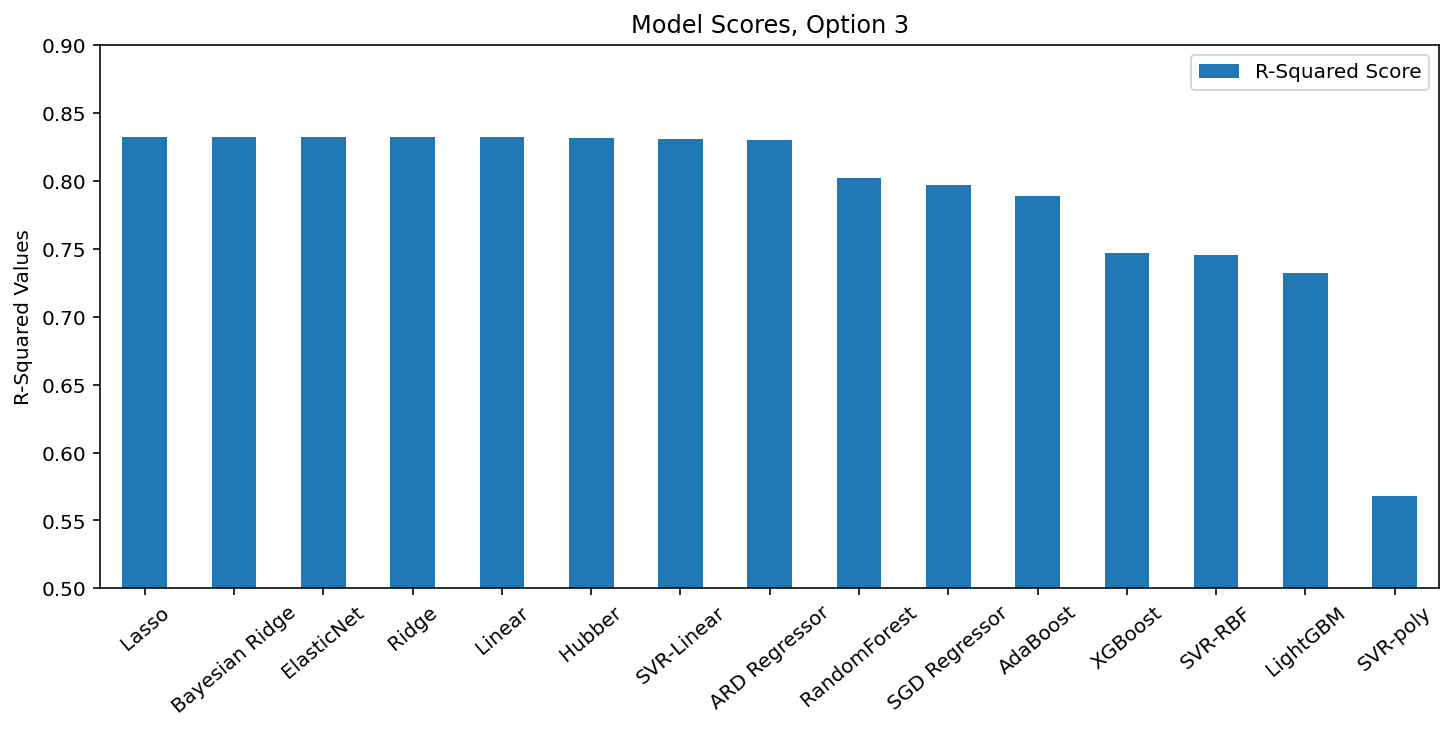

In [52]:
df_results_option_3 = model_training(X3_train_scaled,y3_train,3)

df_results_option_3

In [53]:
model_select = BayesianRidge()

params = {'alpha_1' : [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'alpha_2' : [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'lambda_1': [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'lambda_2': [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'fit_intercept' : [False,True],
          'n_iter' : [100,200,300,400,500,600,700]
         }

model_best = opt_best_model(model_select,params,X3_train_scaled,y3_train)

{'alpha_1': 1e-06,
 'alpha_2': 0.01,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 0.3,
 'lambda_2': 1e-05,
 'n_iter': 500,
 'normalize': False,
 'tol': 0.001,
 'verbose': False}
BayesianRidge(alpha_1=1e-06, alpha_2=0.01, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=0.3, lambda_2=1e-05, n_iter=500,
              normalize=False, tol=0.001, verbose=False)


In [54]:
model_coeffs = model_best_predict(model_best,X3_train_scaled,X3_test_scaled,y3_train,y3_test)

R2-Score   : 0.843678
RMSE-Train : $170,035,980.40
RMSE-Test  : $140,954,398.75


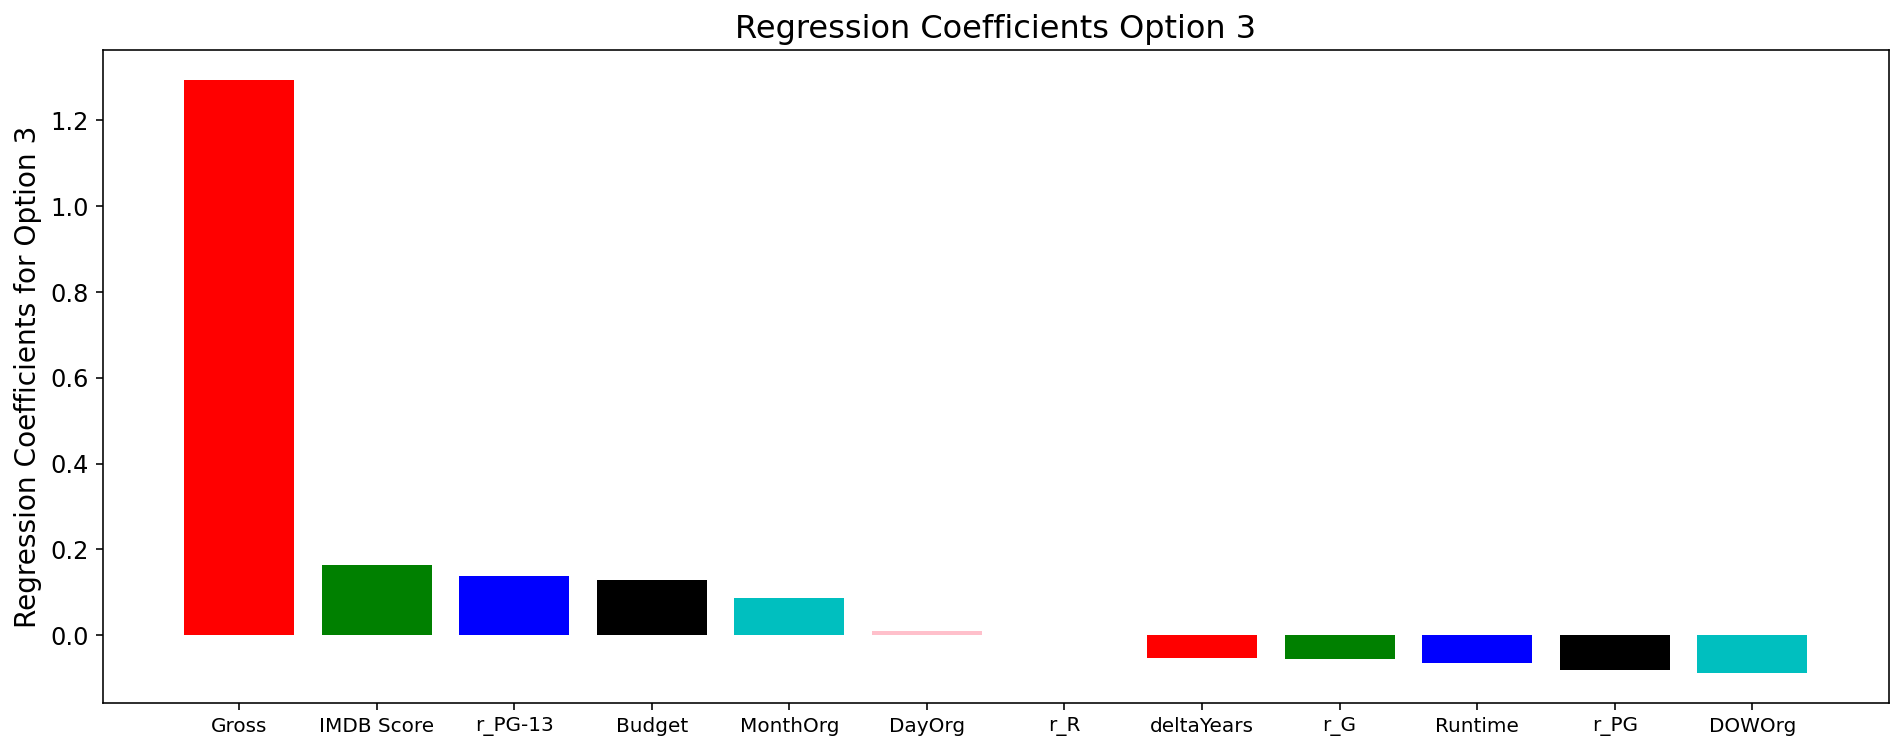

In [55]:
option = 3

plot_coefficients(X3_train,model_coeffs,option)

### Modeling - Option 4

4. Number 3 with Genres

In [56]:
X4 = pd.concat([X3, df_genres], axis=1)

X4.head()

,IMDB Score,Runtime,deltaYears,LogBudget,LogGross,MonthOrg,DOWOrg,DayOrg,r_G,r_PG,...,g_Horror,g_Music,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Sport,g_Thriller,g_War,g_Western
0,7.3,121,2.160209,18.749984,20.530924,5,4,3,0,0,...,0,0,0,0,0,1,0,0,0,0
1,8.7,136,4.123288,17.958645,19.958287,3,2,31,0,0,...,0,0,0,0,0,1,0,0,0,0
2,8.8,178,0.996598,18.348110,20.604294,12,2,19,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8.9,201,8.994025,18.358805,20.856239,12,2,17,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7.8,161,1.010288,19.231611,20.680741,12,4,13,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
# Train-test split for Option 4
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y, test_size=test_size, random_state=1234)


In [58]:
X4_train_scaled,X4_test_scaled,y4_train,y4_test = split_and_merge_again(X4_train,X4_test,y4_train,y4_test)


,R-Squared Score
Bayesian Ridge,0.824662
ARD Regressor,0.820789
Lasso,0.818891
ElasticNet,0.818052
Linear,0.815523
Ridge,0.814041
SVR-Linear,0.812035
Hubber,0.811516
RandomForest,0.804516
SVR-RBF,0.794114


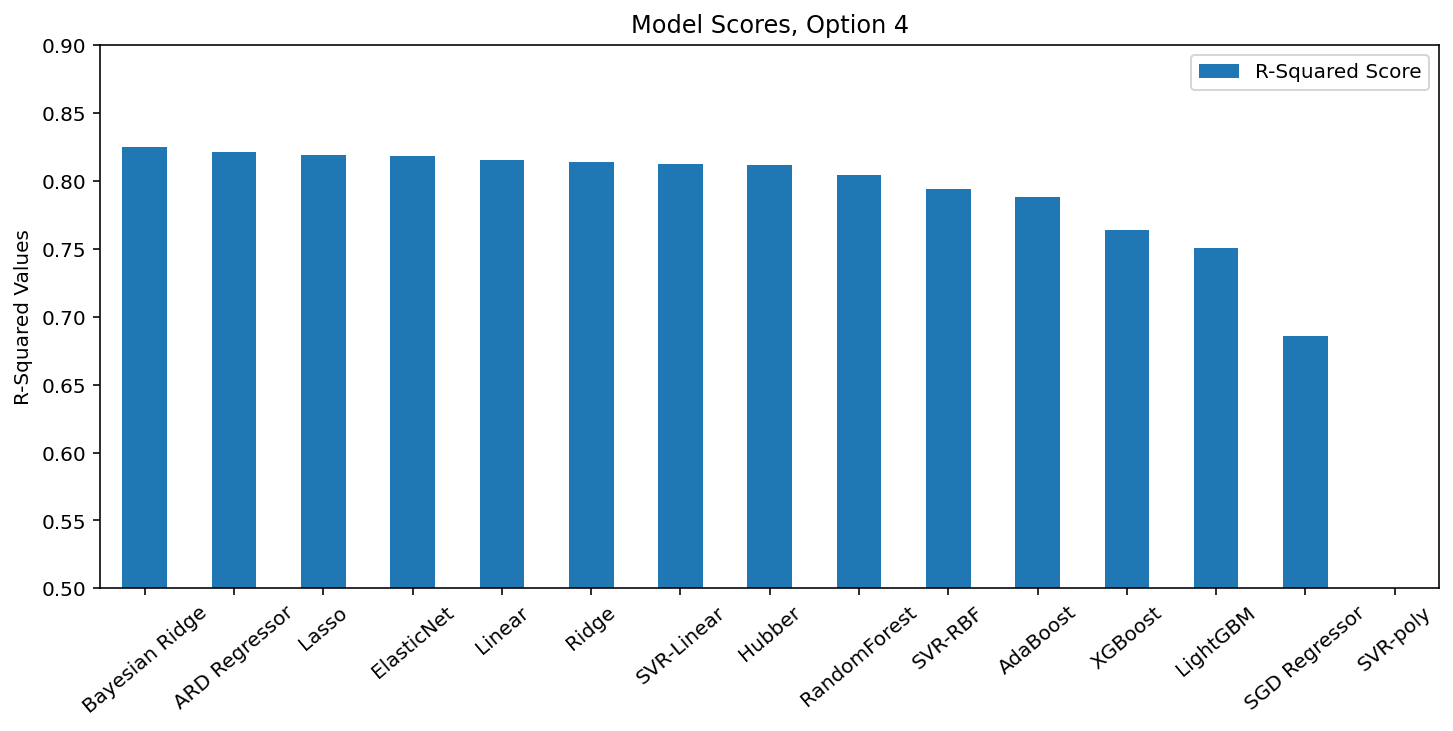

In [59]:
option = 4

df_results_option_4 = model_training(X4_train_scaled,y4_train,option)

df_results_option_4

Here there are too many categorical features for the Genre itself and is thus causing some of the Regressors to perform really poorly. One way to fix this is to decrease the number of unique genres and pick the top 10 or so.

In [60]:
model_select = BayesianRidge()

params = {'alpha_1' : [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'alpha_2' : [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'lambda_1': [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'lambda_2': [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'fit_intercept' : [False,True],
          'n_iter' : [100,200,300,400,500,600,700,800,900,1000]
         }

model_best = opt_best_model(model_select,params,X4_train_scaled,y4_train)

{'alpha_1': 1e-05,
 'alpha_2': 0.2,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 0.1,
 'lambda_2': 0.0001,
 'n_iter': 100,
 'normalize': False,
 'tol': 0.001,
 'verbose': False}
BayesianRidge(alpha_1=1e-05, alpha_2=0.2, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=0.1, lambda_2=0.0001, n_iter=100,
              normalize=False, tol=0.001, verbose=False)


In [61]:
model_coeffs = model_best_predict(model_best,X4_train_scaled,X4_test_scaled,y4_train,y4_test)

R2-Score   : 0.851956
RMSE-Train : $165,232,439.89
RMSE-Test  : $139,747,225.46


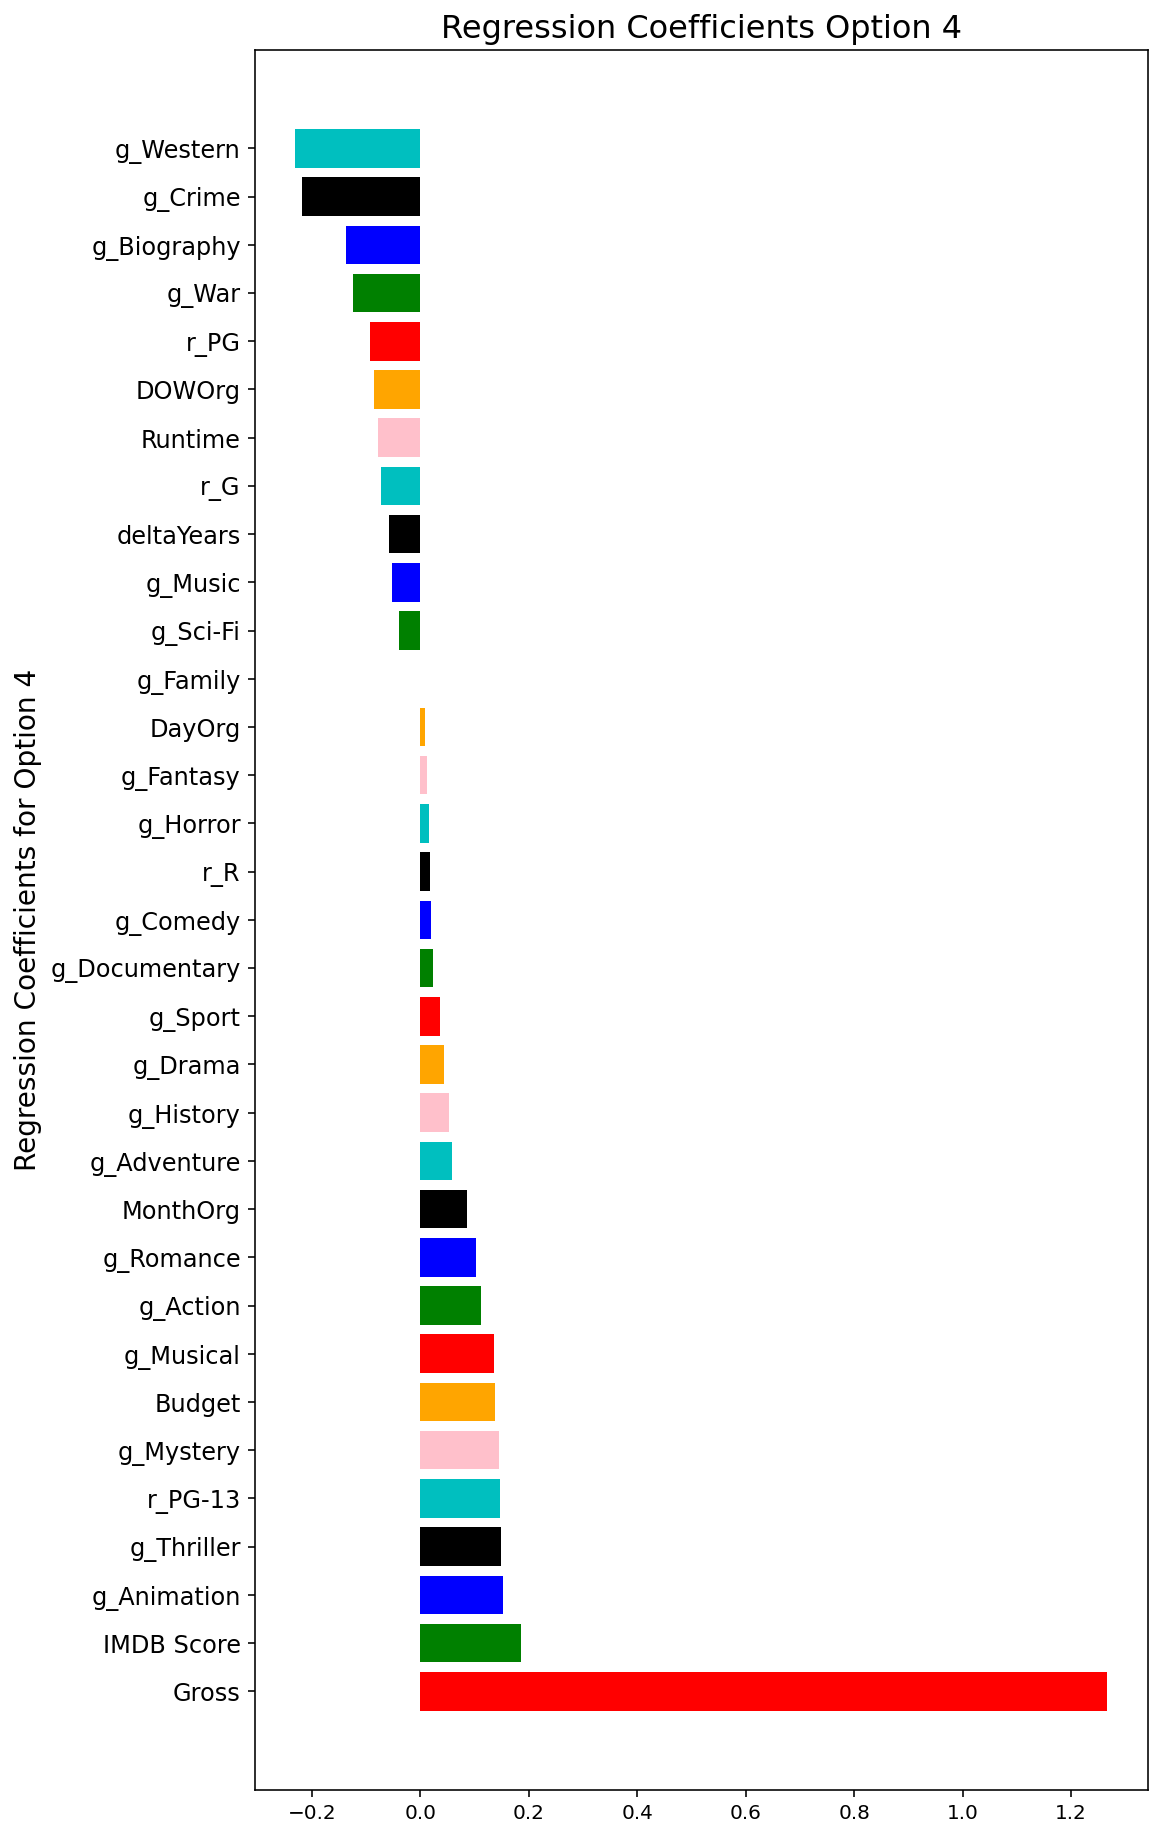

In [62]:
option = 4

plot_coefficients(X4_train,model_coeffs,option,'h')

#### Plot Residuals

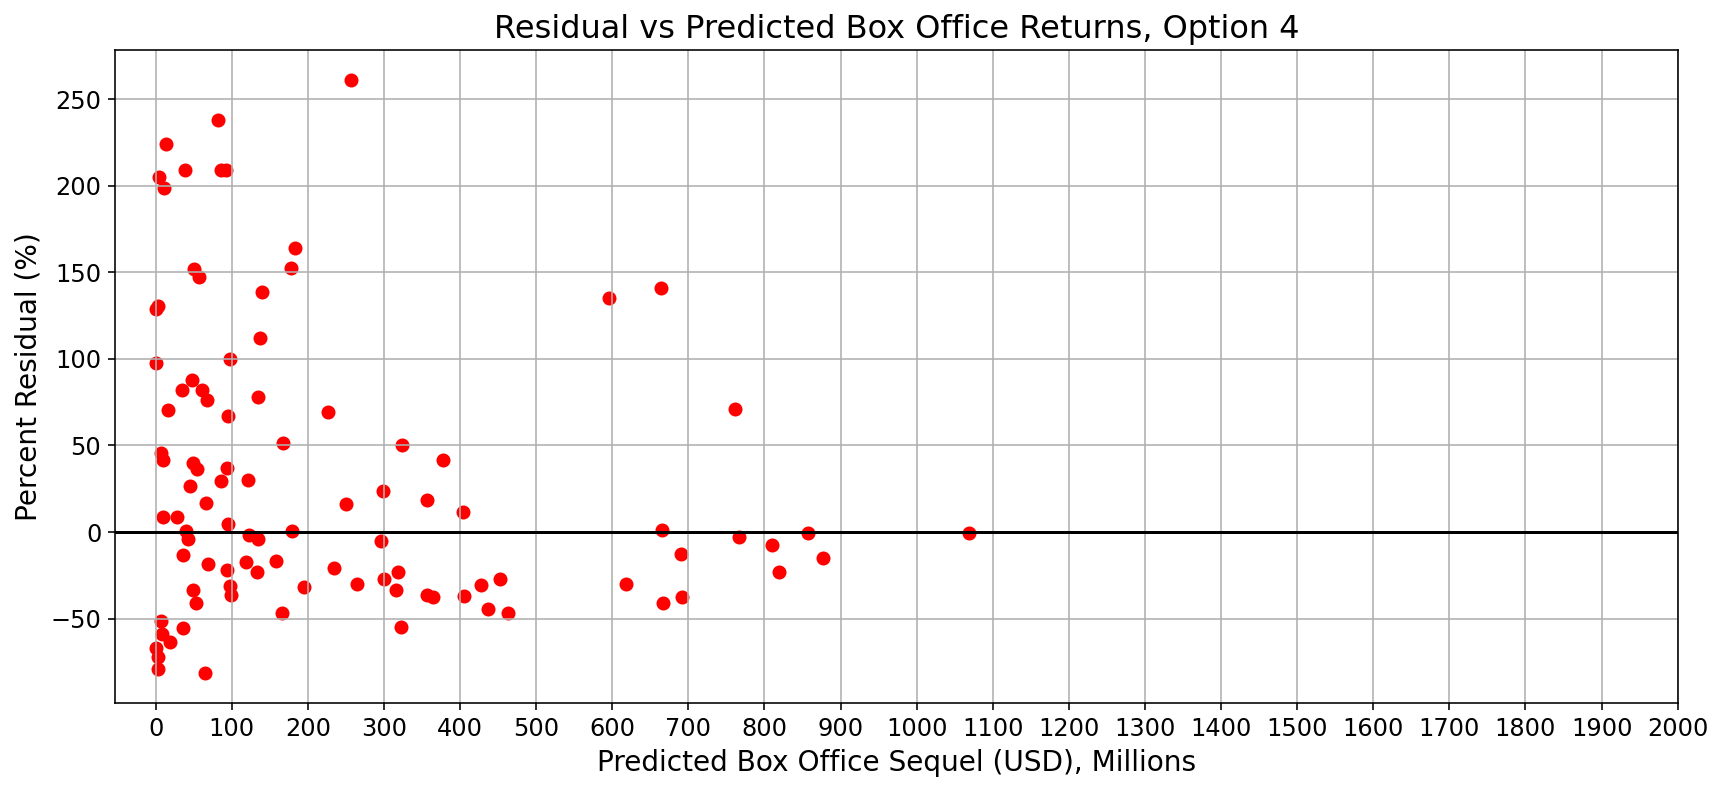

In [63]:
# Look at residuals

option = 4
zoom = 'N'

plot_residuals(model_best,X4_test_scaled,y4_test,zoom,option)

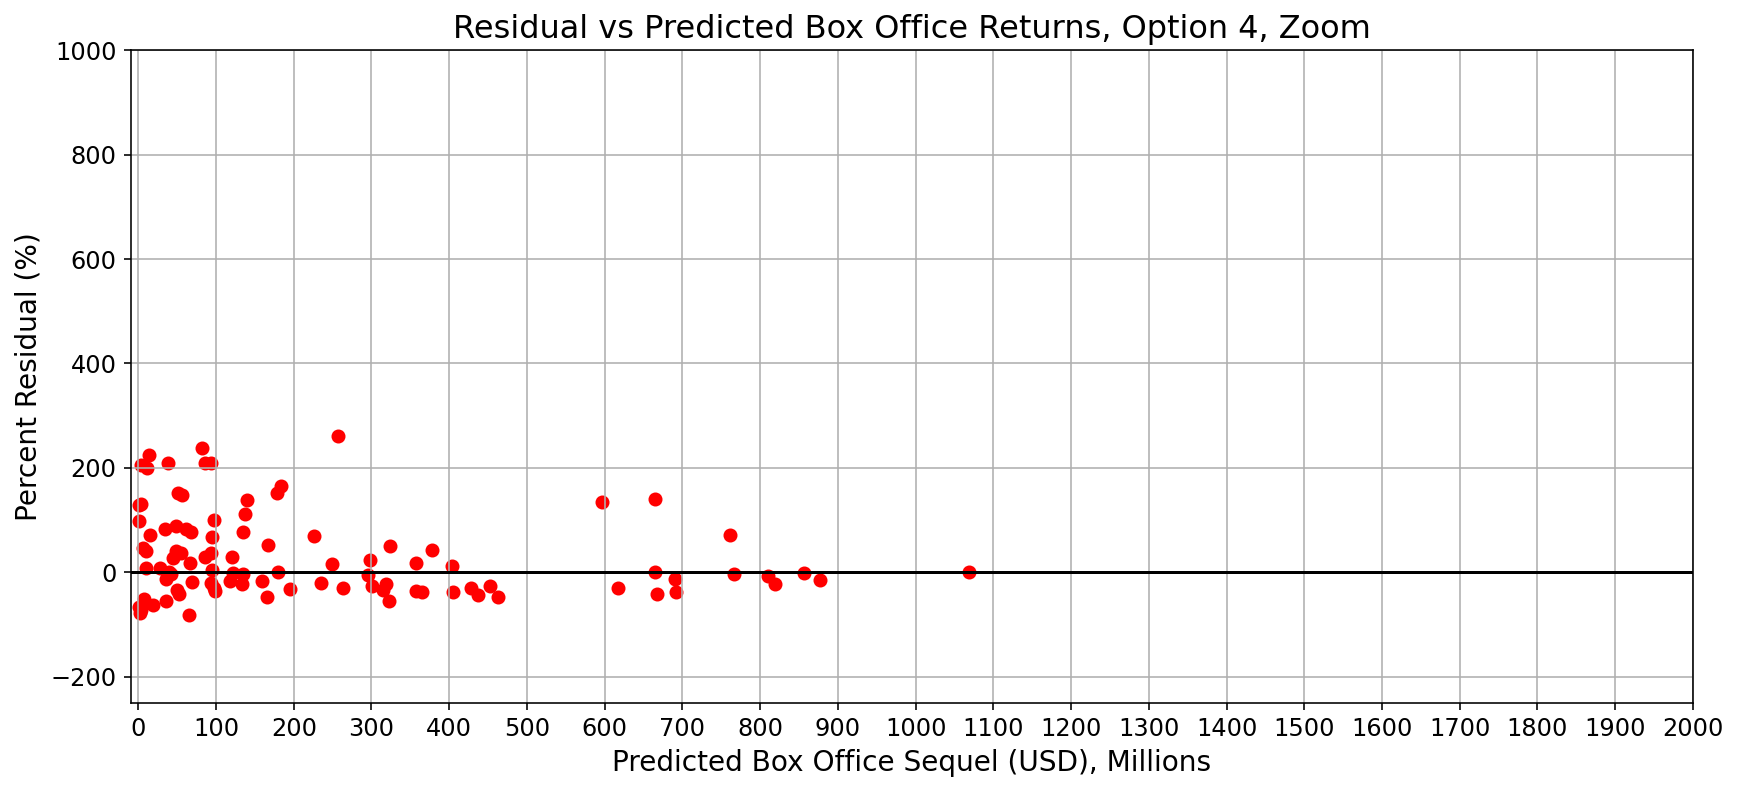

In [64]:
option = 4
zoom = 'Y'

plot_residuals(model_best,X4_test_scaled,y4_test,zoom,option)

# Comments & Remarks

After going through several options of modeling, the highest R2 score achieved is 0.75. This is not bad considering that the design matrix, `[X]*b = y`, has almost no prior knowledge regarding details of its sequel. The exception here is that the design matrix has information about when the release date of the sequel is going to be. A potentially more accurate way will be to include the allocated budget for its sequel, i.e. the sequel has been green lit based on the success of its original. 

# Budget Sequel as a Feature

If a movie sequel has already been green-lit, and budget already allocated, the sequel budget itself could be included as a feature. This is a nice experiment. We can start all with the pure numerical features.

In [65]:
df_org.head()

,IMDB Score,Runtime,deltaYears,MonthOrg,DOWOrg,DayOrg,LogBudget,LogGross
0,7.3,121,2.160209,5,4,3,18.749984,20.530924
1,8.7,136,4.123288,3,2,31,17.958645,19.958287
2,8.8,178,0.996598,12,2,19,18.348110,20.604294
3,8.9,201,8.994025,12,2,17,18.358805,20.856239
4,7.8,161,1.010288,12,4,13,19.231611,20.680741


In [66]:
df_org['LogBudgetSeq'] = np.log(df_seq['Budget'])

In [67]:
df_org.head()

,IMDB Score,Runtime,deltaYears,MonthOrg,DOWOrg,DayOrg,LogBudget,LogGross,LogBudgetSeq
0,7.3,121,2.160209,5,4,3,18.749984,20.530924,19.113828
1,8.7,136,4.123288,3,2,31,17.958645,19.958287,18.826146
2,8.8,178,0.996598,12,2,19,18.348110,20.604294,18.358805
3,8.9,201,8.994025,12,2,17,18.358805,20.856239,19.008467
4,7.8,161,1.010288,12,4,13,19.231611,20.680741,19.336971


In [68]:
# Let's drop MonthOrg, DOWOrg and DayOrg

#X5 = df_org.drop(['MonthOrg','DOWOrg','DayOrg'],axis=1)
X5 = df_org

print(X5.shape)
print(y.shape)

(488, 9)
(488,)


,R-Squared Score
SVR-Linear,0.833754
Lasso,0.832954
Bayesian Ridge,0.832929
ElasticNet,0.832924
Hubber,0.832909
Ridge,0.832876
Linear,0.832876
ARD Regressor,0.831959
SGD Regressor,0.831767
RandomForest,0.802462


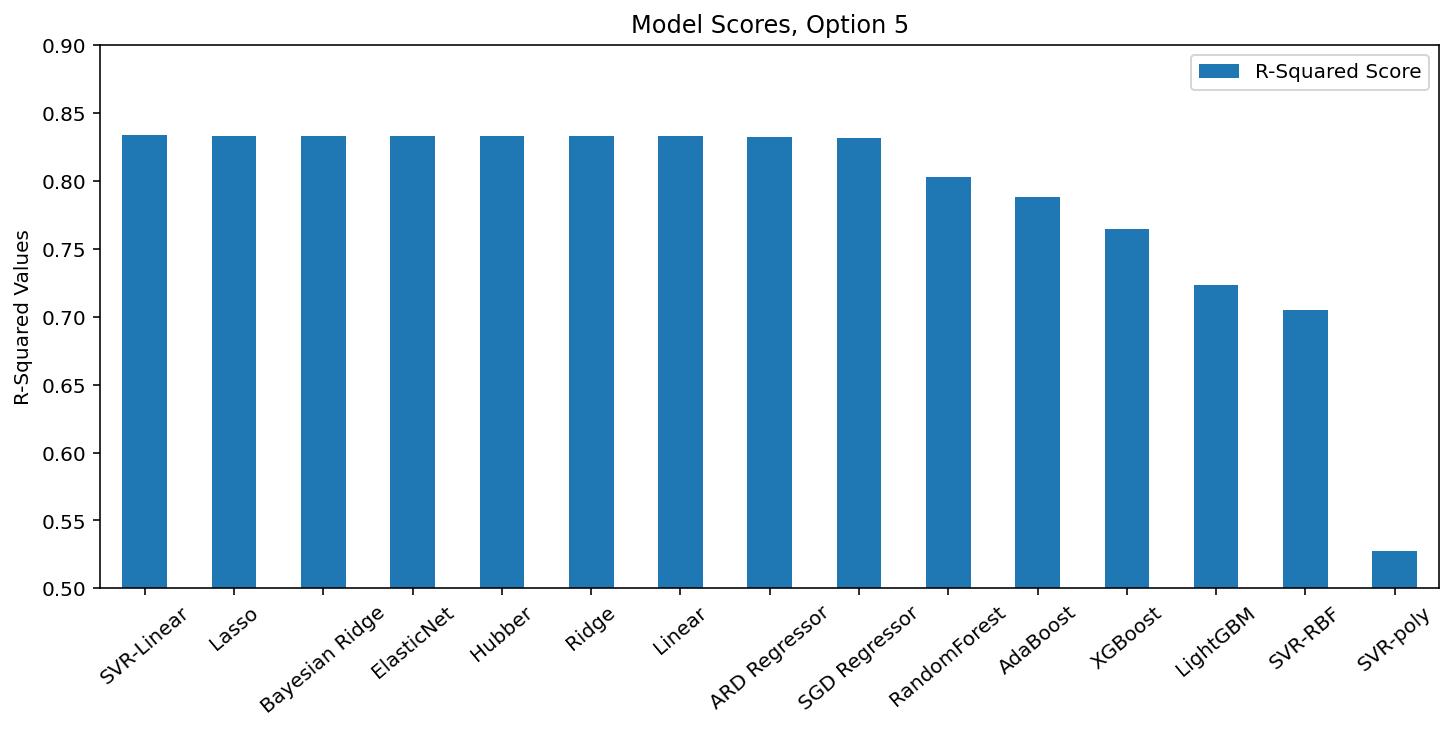

In [69]:
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y, test_size=test_size, random_state=seed)

# Standardize training data
sc5 = StandardScaler()

X5_train_scaled = pd.DataFrame(sc5.fit_transform(X5_train), columns=X5_train.columns)
X5_test_scaled  = pd.DataFrame(sc5.transform(X5_test), columns=X5_test.columns)

option = 5

df_results_option_5 = model_training(X5_train_scaled,y5_train,option)

df_results_option_5

In [70]:
# Pick a model and perform hyper-parameter tuning

model_select5 = BayesianRidge()

params5 = {'alpha_1' : [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
           'alpha_2' : [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
           'lambda_1': [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
           'lambda_2': [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
           'fit_intercept' : [False,True],
           'n_iter' : [100,200,300,400,500,600,700,800,900,1000]
          }

model_best5 = opt_best_model(model_select5,params5,X5_train_scaled,y5_train)

print()
print()

model_coeffs_5 = model_best_predict(model_best,X5_train_scaled,X5_test_scaled,y5_train,y5_test)

{'alpha_1': 1e-06,
 'alpha_2': 0.0001,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 0.3,
 'lambda_2': 1e-07,
 'n_iter': 200,
 'normalize': False,
 'tol': 0.001,
 'verbose': False}
BayesianRidge(alpha_1=1e-06, alpha_2=0.0001, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=0.3, lambda_2=1e-07, n_iter=200,
              normalize=False, tol=0.001, verbose=False)


R2-Score   : 0.843873
RMSE-Train : $173,246,162.67
RMSE-Test  : $152,859,009.28


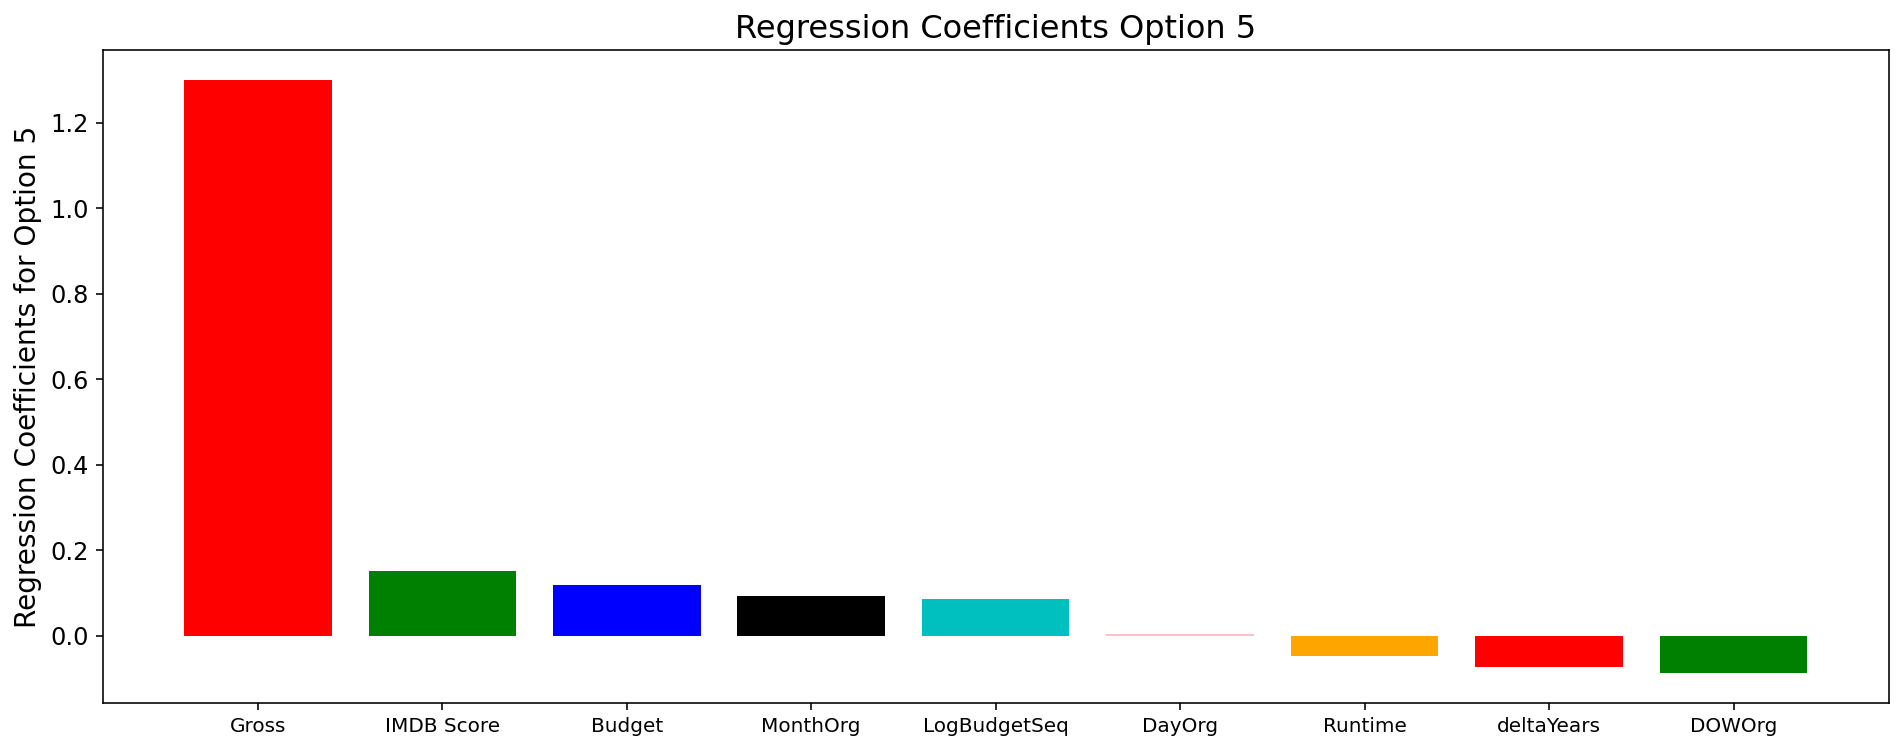

In [71]:
plot_coefficients(X5_train_scaled,model_coeffs_5,5)

The budget sequel does not appear to influence the outcome too much. 

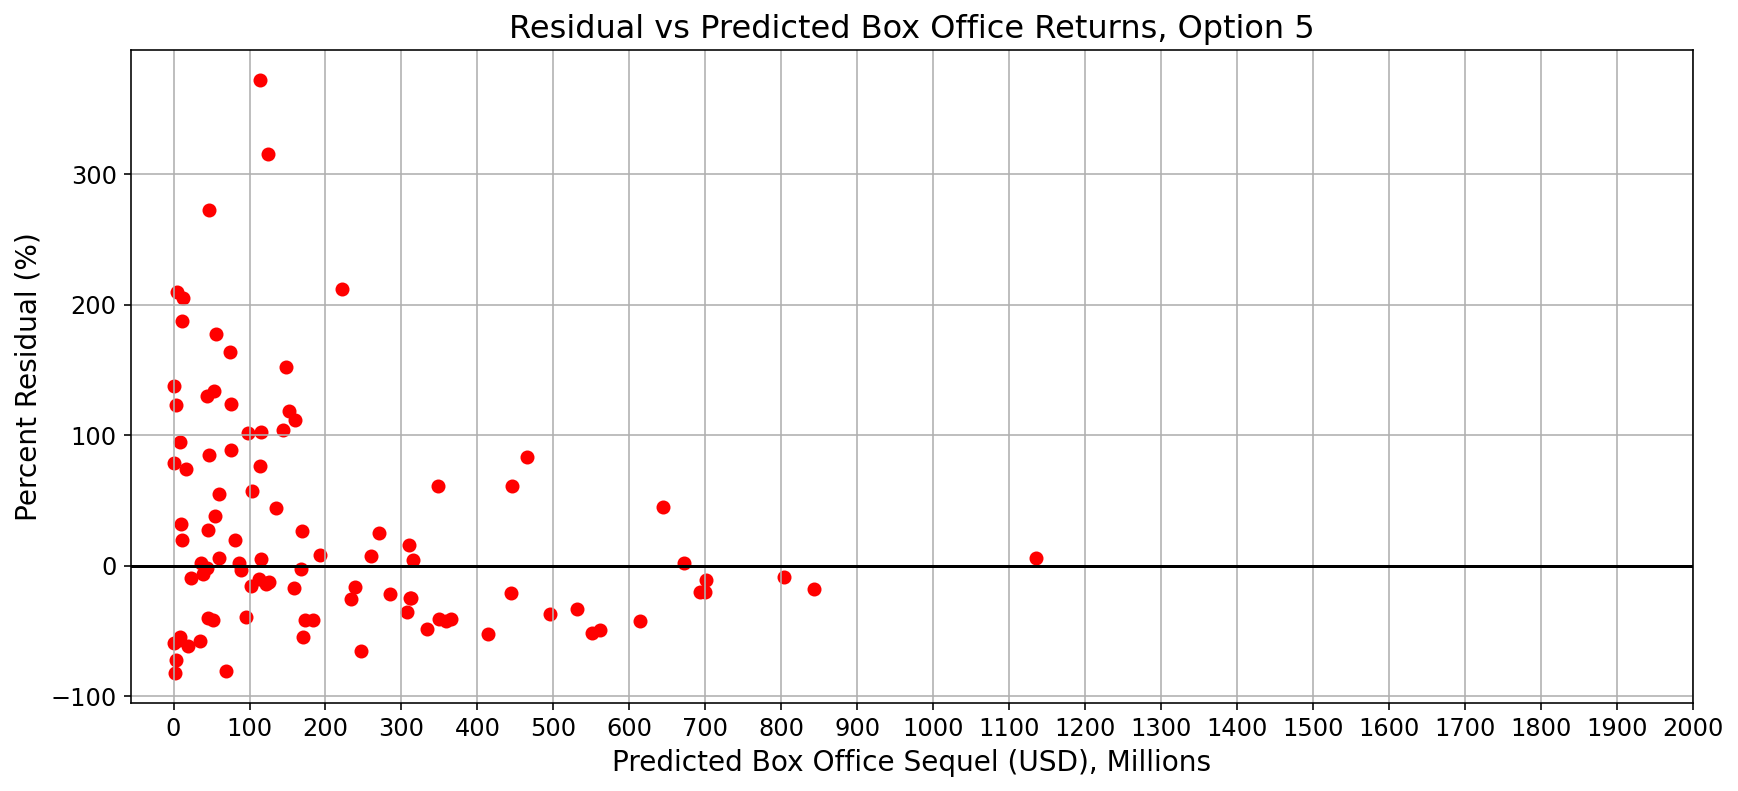

In [72]:
# Look at residuals

option = 5
zoom = 'N'

plot_residuals(model_best5,X5_test_scaled,y5_test,zoom,option)

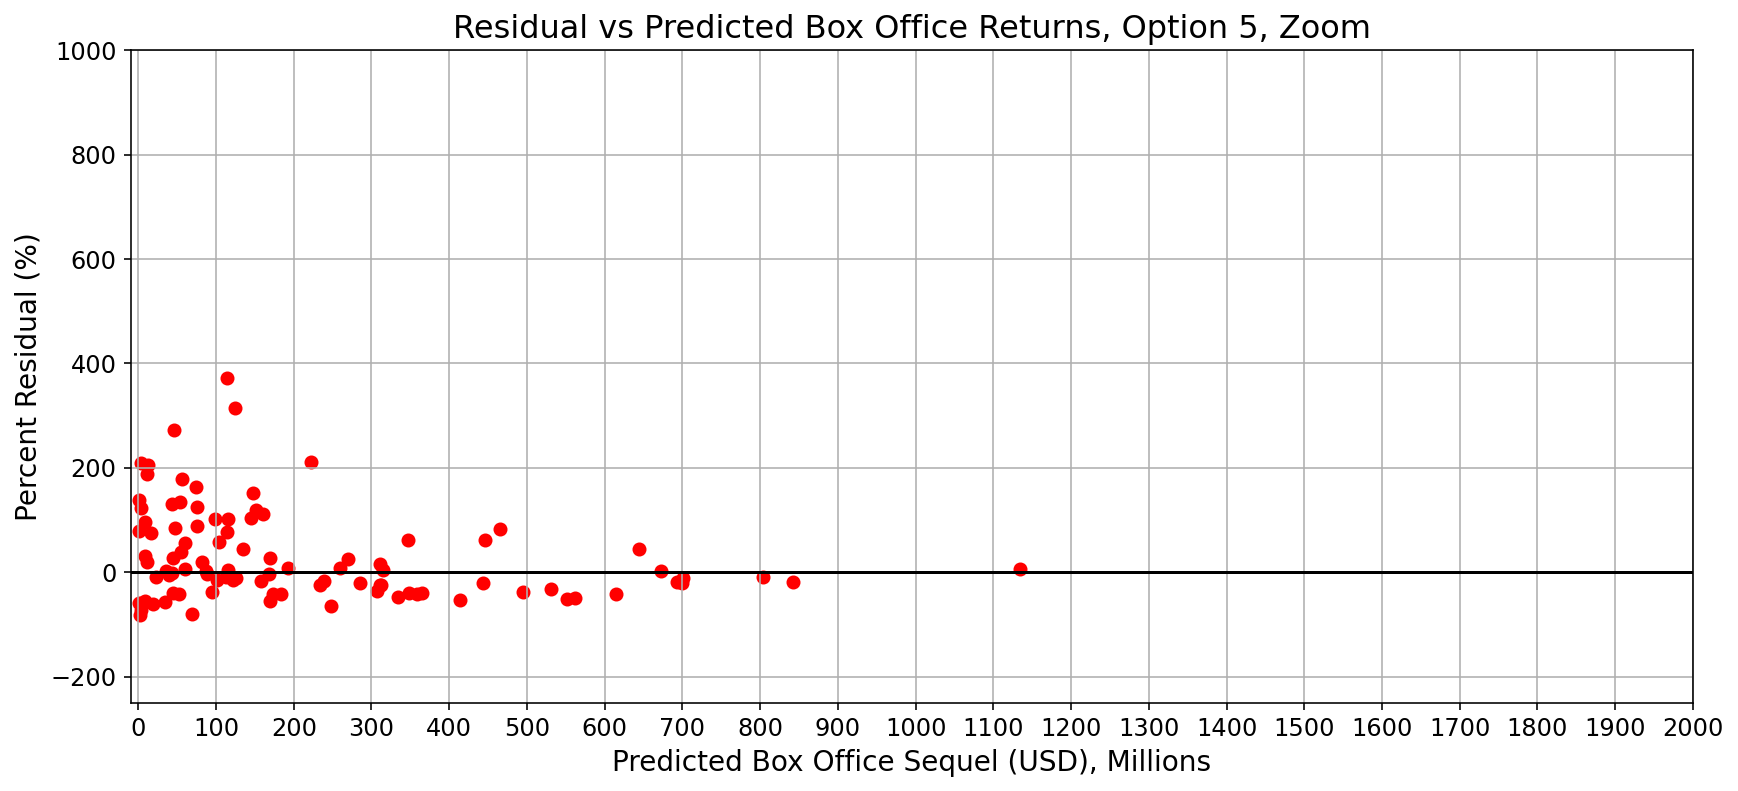

In [73]:
# Look at residuals

option = 5
zoom = 'Y'

plot_residuals(model_best5,X5_test_scaled,y5_test,zoom,option)

Adding the sequel budget did not improve the R2 score by much at all. If one looks at the residual plot, there are still severe outliers below the sequel box-office of USD 200 million. Take a look at these values but I have a hunch there are related to the outliers where the sequel made considerably more compared to the its original.

# Further Comments and Remarks

Within the realm of predicting the box office returns for a movie sequel,